In [22]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
#plt.switch_backend('agg')

In [23]:
#保存打印文件
f = open("1.4torchLSTM.txt", 'a+')

In [24]:
#读取数据集，进行划分
def sliding_window(seq,window_size):
    result = []
    for i in range(len(seq)- window_size):
        result.append(seq[i: i+window_size])
    return result

data = np.load("./实验4-数据/高速公路传感器数据/PEMS04/PEMS04.npz")
#因为数据集过大，这里只取了第一个传感器的数据
data = data["data"][:,0:1,0:1]
#归一化
dmin,dmax = data.min(),data.max()
data = (data - dmin) / (dmax - dmin)
sensordata_num,sensor_num,_ = data.shape
train_set,test_set = [],[]
for  i in range(sensor_num) :
    train_seq = data[:int(sensordata_num*0.8),i,:]
    test_seq = data[int(sensordata_num*0.8):,i,:]
    train_set += sliding_window(train_seq,window_size=13)
    test_set += sliding_window(test_seq,window_size=13)
train_set,test_set= np.array(train_set).squeeze(), np.array(test_set).squeeze()
print(train_set.shape,test_set.shape)
print(train_set,test_set)

(13580, 13) (3386, 13)
[[0.09904153 0.09744409 0.11341853 ... 0.2284345  0.22683706 0.23162939]
 [0.09744409 0.11341853 0.13738019 ... 0.22683706 0.23162939 0.25878594]
 [0.11341853 0.13738019 0.16453674 ... 0.23162939 0.25878594 0.20127796]
 ...
 [0.0798722  0.09105431 0.06389776 ... 0.08626198 0.05591054 0.07667732]
 [0.09105431 0.06389776 0.07188498 ... 0.05591054 0.07667732 0.07827476]
 [0.06389776 0.07188498 0.07507987 ... 0.07667732 0.07827476 0.1086262 ]] [[0.11182109 0.13897764 0.08785942 ... 0.15335463 0.15974441 0.17891374]
 [0.13897764 0.08785942 0.07827476 ... 0.15974441 0.17891374 0.16453674]
 [0.08785942 0.07827476 0.07188498 ... 0.17891374 0.16453674 0.15974441]
 ...
 [0.24920128 0.21246006 0.17891374 ... 0.11182109 0.1086262  0.11980831]
 [0.21246006 0.17891374 0.19648562 ... 0.1086262  0.11980831 0.10543131]
 [0.17891374 0.19648562 0.1884984  ... 0.11980831 0.10543131 0.12300319]]


In [25]:
device = 'cpu'
torch_lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
output_model = nn.Linear(32, 1)

In [26]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(torch_lstm.parameters()) + list(output_model.parameters()), lr=0.0001)

In [27]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [28]:
def next_batch(data, batch_size):
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

In [29]:
#反归一化
def denormalize(x):
    return x * (dmax - dmin) + dmin

In [30]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch 
for epoch in range(100):
   
    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=128):
        #每一个batch的开始时间
        batchstart = time.time()
        
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :12], batch[:, -1]
        out, hidden = torch_lstm(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
        out = output_model(out[:, -1, :])
        prediction = out.squeeze(-1)  # (batch)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (prediction == label).sum().item()
        #累加loss
        #total_1oss += loss.item( )
        trained_batches += 1
         #计算平均oss与准确率
        #train_loss = total_1oss / train_batch_num
        #train_log.append(train_loss)   
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        #if trained_batches % 100 == 0:
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time),file=f)
    
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :12], batch[:, -1]
                out, hidden = torch_lstm(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
                out = output_model(out[:, -1, :])
                prediction = out.squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time),file=f)

        #每一个epoch的结束时间
        #elapsed = (time.time() - epochstart)
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed))
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed),file=f)
    
#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))
print('The total time is %fs'%(timesum),file=f)
f.close()

batch 1, train_loss 0.298577,Time used 0.021940s
batch 2, train_loss 0.339651,Time used 0.014960s
batch 3, train_loss 0.310571,Time used 0.013963s
batch 4, train_loss 0.328669,Time used 0.011969s
batch 5, train_loss 0.301635,Time used 0.013963s
batch 6, train_loss 0.328302,Time used 0.013963s
batch 7, train_loss 0.308785,Time used 0.012966s
batch 8, train_loss 0.277442,Time used 0.013963s
batch 9, train_loss 0.304451,Time used 0.015957s
batch 10, train_loss 0.267613,Time used 0.015957s
batch 11, train_loss 0.291756,Time used 0.012966s
batch 12, train_loss 0.309504,Time used 0.012966s
batch 13, train_loss 0.327392,Time used 0.013963s
batch 14, train_loss 0.324703,Time used 0.013963s
batch 15, train_loss 0.274058,Time used 0.014961s
batch 16, train_loss 0.318092,Time used 0.013962s
batch 17, train_loss 0.304043,Time used 0.012965s
batch 18, train_loss 0.292967,Time used 0.013963s
batch 19, train_loss 0.282839,Time used 0.013963s
batch 20, train_loss 0.279257,Time used 0.012965s
batch 21,

batch 164, train_loss 0.144005,Time used 0.016955s
batch 165, train_loss 0.140767,Time used 0.015958s
batch 166, train_loss 0.168964,Time used 0.014960s
batch 167, train_loss 0.159834,Time used 0.015958s
batch 168, train_loss 0.147562,Time used 0.016955s
batch 169, train_loss 0.169776,Time used 0.015958s
batch 170, train_loss 0.146192,Time used 0.015958s
batch 171, train_loss 0.181151,Time used 0.016954s
batch 172, train_loss 0.163202,Time used 0.015958s
batch 173, train_loss 0.140435,Time used 0.016954s
batch 174, train_loss 0.146568,Time used 0.016954s
batch 175, train_loss 0.161071,Time used 0.015958s
batch 176, train_loss 0.169988,Time used 0.016955s
batch 177, train_loss 0.166131,Time used 0.016955s
batch 178, train_loss 0.161291,Time used 0.016955s
batch 179, train_loss 0.167848,Time used 0.015957s
batch 180, train_loss 0.137092,Time used 0.016955s
batch 181, train_loss 0.170095,Time used 0.016954s
batch 182, train_loss 0.133444,Time used 0.015959s
batch 183, train_loss 0.136653,

batch 322, train_loss 0.022227,Time used 0.017953s
batch 323, train_loss 0.029736,Time used 0.016955s
batch 324, train_loss 0.023513,Time used 0.017951s
batch 325, train_loss 0.025651,Time used 0.015957s
batch 326, train_loss 0.023872,Time used 0.017952s
batch 327, train_loss 0.024674,Time used 0.015957s
batch 328, train_loss 0.025829,Time used 0.016954s
batch 329, train_loss 0.021025,Time used 0.015958s
batch 330, train_loss 0.023197,Time used 0.015958s
batch 331, train_loss 0.026045,Time used 0.015957s
batch 332, train_loss 0.024459,Time used 0.017952s
batch 333, train_loss 0.029813,Time used 0.017951s
batch 334, train_loss 0.025546,Time used 0.017952s
batch 335, train_loss 0.026929,Time used 0.016955s
batch 336, train_loss 0.025247,Time used 0.017951s
batch 337, train_loss 0.021394,Time used 0.016954s
batch 338, train_loss 0.026335,Time used 0.017951s
batch 339, train_loss 0.024615,Time used 0.017953s
batch 340, train_loss 0.029413,Time used 0.016954s
batch 341, train_loss 0.021343,

batch 486, train_loss 0.016186,Time used 0.016956s
batch 487, train_loss 0.020048,Time used 0.016954s
batch 488, train_loss 0.016073,Time used 0.016955s
batch 489, train_loss 0.017721,Time used 0.015956s
batch 490, train_loss 0.017214,Time used 0.017953s
batch 491, train_loss 0.017670,Time used 0.016954s
batch 492, train_loss 0.016882,Time used 0.016955s
batch 493, train_loss 0.016911,Time used 0.016955s
batch 494, train_loss 0.017718,Time used 0.015957s
batch 495, train_loss 0.016041,Time used 0.016954s
batch 496, train_loss 0.017198,Time used 0.016955s
batch 497, train_loss 0.017573,Time used 0.016955s
batch 498, train_loss 0.019106,Time used 0.017952s
batch 499, train_loss 0.015621,Time used 0.016955s
batch 500, train_loss 0.017884,Time used 0.016954s
***************************test_batch 500, test_rmse_loss 0.127202,test_mae_loss 0.105441,test_mape_loss 73.372636,Time used 0.226396s
batch 501, train_loss 0.017960,Time used 0.013963s
batch 502, train_loss 0.014728,Time used 0.017952

batch 644, train_loss 0.008674,Time used 0.016955s
batch 645, train_loss 0.011155,Time used 0.016954s
batch 646, train_loss 0.009883,Time used 0.017952s
batch 647, train_loss 0.011823,Time used 0.016955s
batch 648, train_loss 0.011599,Time used 0.016955s
batch 649, train_loss 0.010264,Time used 0.016955s
batch 650, train_loss 0.009848,Time used 0.016954s
batch 651, train_loss 0.010115,Time used 0.016955s
batch 652, train_loss 0.009914,Time used 0.016955s
batch 653, train_loss 0.012871,Time used 0.015957s
batch 654, train_loss 0.008593,Time used 0.014960s
batch 655, train_loss 0.009192,Time used 0.016955s
batch 656, train_loss 0.010175,Time used 0.015958s
batch 657, train_loss 0.009652,Time used 0.016953s
batch 658, train_loss 0.009354,Time used 0.016954s
batch 659, train_loss 0.010774,Time used 0.016955s
batch 660, train_loss 0.010579,Time used 0.015958s
batch 661, train_loss 0.008549,Time used 0.015958s
batch 662, train_loss 0.010797,Time used 0.015958s
batch 663, train_loss 0.010562,

batch 812, train_loss 0.006840,Time used 0.015958s
batch 813, train_loss 0.008041,Time used 0.015957s
batch 814, train_loss 0.007644,Time used 0.016955s
batch 815, train_loss 0.004861,Time used 0.016955s
batch 816, train_loss 0.005393,Time used 0.015957s
batch 817, train_loss 0.005958,Time used 0.016955s
batch 818, train_loss 0.007342,Time used 0.015958s
batch 819, train_loss 0.006937,Time used 0.015958s
batch 820, train_loss 0.007247,Time used 0.015958s
batch 821, train_loss 0.005598,Time used 0.015957s
batch 822, train_loss 0.006698,Time used 0.015958s
batch 823, train_loss 0.007471,Time used 0.015958s
batch 824, train_loss 0.006868,Time used 0.015958s
batch 825, train_loss 0.007769,Time used 0.015958s
batch 826, train_loss 0.006336,Time used 0.015957s
batch 827, train_loss 0.006776,Time used 0.016955s
batch 828, train_loss 0.006139,Time used 0.015957s
batch 829, train_loss 0.007009,Time used 0.015958s
batch 830, train_loss 0.006419,Time used 0.016954s
batch 831, train_loss 0.006556,

batch 978, train_loss 0.007697,Time used 0.015957s
batch 979, train_loss 0.005844,Time used 0.016955s
batch 980, train_loss 0.007746,Time used 0.015958s
batch 981, train_loss 0.008482,Time used 0.016955s
batch 982, train_loss 0.010232,Time used 0.015957s
batch 983, train_loss 0.005445,Time used 0.014959s
batch 984, train_loss 0.006674,Time used 0.015957s
batch 985, train_loss 0.005147,Time used 0.014960s
batch 986, train_loss 0.006285,Time used 0.015957s
batch 987, train_loss 0.007680,Time used 0.015957s
batch 988, train_loss 0.007622,Time used 0.016955s
batch 989, train_loss 0.006037,Time used 0.015957s
batch 990, train_loss 0.006917,Time used 0.015958s
batch 991, train_loss 0.006083,Time used 0.025985s
batch 992, train_loss 0.005778,Time used 0.016955s
batch 993, train_loss 0.009732,Time used 0.014960s
batch 994, train_loss 0.005959,Time used 0.012966s
batch 995, train_loss 0.006140,Time used 0.015957s
batch 996, train_loss 0.008493,Time used 0.014961s
batch 997, train_loss 0.006276,

batch 1133, train_loss 0.005940,Time used 0.015958s
batch 1134, train_loss 0.006783,Time used 0.017952s
batch 1135, train_loss 0.006269,Time used 0.016954s
batch 1136, train_loss 0.006009,Time used 0.016955s
batch 1137, train_loss 0.004958,Time used 0.016955s
batch 1138, train_loss 0.007261,Time used 0.015957s
batch 1139, train_loss 0.004927,Time used 0.015958s
batch 1140, train_loss 0.007641,Time used 0.016954s
batch 1141, train_loss 0.005846,Time used 0.015958s
batch 1142, train_loss 0.006204,Time used 0.016954s
batch 1143, train_loss 0.005865,Time used 0.016955s
batch 1144, train_loss 0.005183,Time used 0.016954s
batch 1145, train_loss 0.005991,Time used 0.017952s
batch 1146, train_loss 0.006360,Time used 0.017951s
batch 1147, train_loss 0.006410,Time used 0.016956s
batch 1148, train_loss 0.004699,Time used 0.017952s
batch 1149, train_loss 0.004989,Time used 0.016955s
batch 1150, train_loss 0.007715,Time used 0.017952s
batch 1151, train_loss 0.005885,Time used 0.017952s
batch 1152, 

batch 1288, train_loss 0.006384,Time used 0.015957s
batch 1289, train_loss 0.009911,Time used 0.016955s
batch 1290, train_loss 0.004594,Time used 0.015958s
batch 1291, train_loss 0.005422,Time used 0.015958s
batch 1292, train_loss 0.005058,Time used 0.016955s
batch 1293, train_loss 0.005144,Time used 0.016955s
batch 1294, train_loss 0.005644,Time used 0.016954s
batch 1295, train_loss 0.005455,Time used 0.015957s
batch 1296, train_loss 0.006654,Time used 0.015957s
batch 1297, train_loss 0.005297,Time used 0.016956s
batch 1298, train_loss 0.005711,Time used 0.016955s
batch 1299, train_loss 0.005896,Time used 0.016954s
batch 1300, train_loss 0.005065,Time used 0.016954s
***************************test_batch 1300, test_rmse_loss 0.078185,test_mae_loss 0.060169,test_mape_loss 27.444124,Time used 0.225397s
batch 1301, train_loss 0.005833,Time used 0.014960s
batch 1302, train_loss 0.006604,Time used 0.015957s
batch 1303, train_loss 0.007163,Time used 0.015958s
batch 1304, train_loss 0.005131,

batch 1444, train_loss 0.004707,Time used 0.022462s
batch 1445, train_loss 0.006883,Time used 0.017954s
batch 1446, train_loss 0.006900,Time used 0.017951s
batch 1447, train_loss 0.006495,Time used 0.015958s
batch 1448, train_loss 0.005796,Time used 0.016955s
batch 1449, train_loss 0.006378,Time used 0.016955s
batch 1450, train_loss 0.006251,Time used 0.018949s
batch 1451, train_loss 0.005892,Time used 0.017952s
batch 1452, train_loss 0.005972,Time used 0.017953s
batch 1453, train_loss 0.007155,Time used 0.017952s
batch 1454, train_loss 0.007479,Time used 0.015957s
batch 1455, train_loss 0.006224,Time used 0.014960s
batch 1456, train_loss 0.005378,Time used 0.017953s
batch 1457, train_loss 0.006758,Time used 0.017951s
batch 1458, train_loss 0.007237,Time used 0.018950s
batch 1459, train_loss 0.005580,Time used 0.019474s
batch 1460, train_loss 0.005656,Time used 0.017952s
batch 1461, train_loss 0.004488,Time used 0.017952s
batch 1462, train_loss 0.005166,Time used 0.016956s
batch 1463, 

***************************test_batch 1600, test_rmse_loss 0.076466,test_mae_loss 0.058334,test_mape_loss 25.058796,Time used 0.209440s
batch 1601, train_loss 0.006386,Time used 0.013962s
batch 1602, train_loss 0.005796,Time used 0.016955s
batch 1603, train_loss 0.006061,Time used 0.016955s
batch 1604, train_loss 0.006602,Time used 0.016956s
batch 1605, train_loss 0.011951,Time used 0.006981s
batch 1606, train_loss 0.006176,Time used 0.016954s
batch 1607, train_loss 0.006598,Time used 0.016955s
batch 1608, train_loss 0.005457,Time used 0.016954s
batch 1609, train_loss 0.006264,Time used 0.016954s
batch 1610, train_loss 0.005620,Time used 0.015958s
batch 1611, train_loss 0.005536,Time used 0.016954s
batch 1612, train_loss 0.005408,Time used 0.016955s
batch 1613, train_loss 0.005663,Time used 0.016955s
batch 1614, train_loss 0.005922,Time used 0.016954s
batch 1615, train_loss 0.004044,Time used 0.016956s
batch 1616, train_loss 0.006702,Time used 0.015957s
batch 1617, train_loss 0.007763,

batch 1757, train_loss 0.005870,Time used 0.016955s
batch 1758, train_loss 0.005633,Time used 0.016955s
batch 1759, train_loss 0.005242,Time used 0.016955s
batch 1760, train_loss 0.005304,Time used 0.015958s
batch 1761, train_loss 0.005997,Time used 0.015957s
batch 1762, train_loss 0.004612,Time used 0.015958s
batch 1763, train_loss 0.007009,Time used 0.016955s
batch 1764, train_loss 0.004500,Time used 0.016954s
batch 1765, train_loss 0.005116,Time used 0.015957s
batch 1766, train_loss 0.005430,Time used 0.015958s
batch 1767, train_loss 0.006296,Time used 0.016955s
batch 1768, train_loss 0.006976,Time used 0.016956s
batch 1769, train_loss 0.004304,Time used 0.016954s
batch 1770, train_loss 0.005259,Time used 0.016955s
batch 1771, train_loss 0.004637,Time used 0.016955s
batch 1772, train_loss 0.007614,Time used 0.016956s
batch 1773, train_loss 0.007832,Time used 0.016956s
batch 1774, train_loss 0.004927,Time used 0.016954s
batch 1775, train_loss 0.004684,Time used 0.016955s
batch 1776, 

batch 1911, train_loss 0.004459,Time used 0.017952s
batch 1912, train_loss 0.004576,Time used 0.017953s
batch 1913, train_loss 0.005563,Time used 0.013963s
batch 1914, train_loss 0.003940,Time used 0.014961s
batch 1915, train_loss 0.006245,Time used 0.015957s
batch 1916, train_loss 0.004527,Time used 0.013963s
batch 1917, train_loss 0.005988,Time used 0.015958s
batch 1918, train_loss 0.006775,Time used 0.016954s
batch 1919, train_loss 0.005105,Time used 0.016955s
batch 1920, train_loss 0.006086,Time used 0.016955s
batch 1921, train_loss 0.005326,Time used 0.016955s
batch 1922, train_loss 0.005979,Time used 0.017952s
batch 1923, train_loss 0.006752,Time used 0.017951s
batch 1924, train_loss 0.003589,Time used 0.016972s
batch 1925, train_loss 0.005470,Time used 0.016955s
batch 1926, train_loss 0.005099,Time used 0.006981s
batch 1927, train_loss 0.006010,Time used 0.016954s
batch 1928, train_loss 0.005508,Time used 0.017952s
batch 1929, train_loss 0.006059,Time used 0.017952s
batch 1930, 

batch 2068, train_loss 0.005022,Time used 0.015956s
batch 2069, train_loss 0.004934,Time used 0.017953s
batch 2070, train_loss 0.005483,Time used 0.015958s
batch 2071, train_loss 0.005776,Time used 0.014960s
batch 2072, train_loss 0.005214,Time used 0.016955s
batch 2073, train_loss 0.006288,Time used 0.016954s
batch 2074, train_loss 0.006491,Time used 0.017952s
batch 2075, train_loss 0.005473,Time used 0.016955s
batch 2076, train_loss 0.005708,Time used 0.017952s
batch 2077, train_loss 0.006047,Time used 0.016955s
batch 2078, train_loss 0.008872,Time used 0.016954s
batch 2079, train_loss 0.004885,Time used 0.016955s
batch 2080, train_loss 0.005137,Time used 0.017952s
batch 2081, train_loss 0.007005,Time used 0.016955s
batch 2082, train_loss 0.006915,Time used 0.017952s
batch 2083, train_loss 0.005695,Time used 0.016954s
batch 2084, train_loss 0.005635,Time used 0.016955s
batch 2085, train_loss 0.005645,Time used 0.016956s
batch 2086, train_loss 0.006034,Time used 0.017952s
batch 2087, 

batch 2223, train_loss 0.005434,Time used 0.016954s
batch 2224, train_loss 0.004498,Time used 0.016955s
batch 2225, train_loss 0.005762,Time used 0.016954s
batch 2226, train_loss 0.003882,Time used 0.016955s
batch 2227, train_loss 0.005174,Time used 0.016955s
batch 2228, train_loss 0.005434,Time used 0.017952s
batch 2229, train_loss 0.003676,Time used 0.016956s
batch 2230, train_loss 0.006153,Time used 0.015957s
batch 2231, train_loss 0.005074,Time used 0.016955s
batch 2232, train_loss 0.004874,Time used 0.016954s
batch 2233, train_loss 0.007291,Time used 0.015957s
batch 2234, train_loss 0.006683,Time used 0.017952s
batch 2235, train_loss 0.005941,Time used 0.016954s
batch 2236, train_loss 0.005446,Time used 0.016955s
batch 2237, train_loss 0.005832,Time used 0.016955s
batch 2238, train_loss 0.004267,Time used 0.016955s
batch 2239, train_loss 0.005437,Time used 0.016954s
batch 2240, train_loss 0.004216,Time used 0.016955s
batch 2241, train_loss 0.004193,Time used 0.015957s
batch 2242, 

batch 2384, train_loss 0.003784,Time used 0.017951s
batch 2385, train_loss 0.005258,Time used 0.015958s
batch 2386, train_loss 0.004308,Time used 0.016954s
batch 2387, train_loss 0.004688,Time used 0.016954s
batch 2388, train_loss 0.004815,Time used 0.015958s
batch 2389, train_loss 0.006974,Time used 0.016955s
batch 2390, train_loss 0.005595,Time used 0.016955s
batch 2391, train_loss 0.006639,Time used 0.017951s
batch 2392, train_loss 0.005384,Time used 0.017952s
batch 2393, train_loss 0.005199,Time used 0.016955s
batch 2394, train_loss 0.007967,Time used 0.017951s
batch 2395, train_loss 0.005638,Time used 0.016955s
batch 2396, train_loss 0.005896,Time used 0.017952s
batch 2397, train_loss 0.004971,Time used 0.016954s
batch 2398, train_loss 0.005618,Time used 0.016955s
batch 2399, train_loss 0.006414,Time used 0.016955s
batch 2400, train_loss 0.004634,Time used 0.015958s
***************************test_batch 2400, test_rmse_loss 0.072655,test_mae_loss 0.054366,test_mape_loss 20.762549,

batch 2542, train_loss 0.004536,Time used 0.016955s
batch 2543, train_loss 0.005427,Time used 0.015957s
batch 2544, train_loss 0.005132,Time used 0.016954s
batch 2545, train_loss 0.004010,Time used 0.016955s
batch 2546, train_loss 0.005659,Time used 0.016956s
batch 2547, train_loss 0.005320,Time used 0.016955s
batch 2548, train_loss 0.004919,Time used 0.016955s
batch 2549, train_loss 0.005009,Time used 0.015958s
batch 2550, train_loss 0.006016,Time used 0.015958s
batch 2551, train_loss 0.005139,Time used 0.015957s
batch 2552, train_loss 0.004966,Time used 0.016955s
batch 2553, train_loss 0.004579,Time used 0.016954s
batch 2554, train_loss 0.005511,Time used 0.017952s
batch 2555, train_loss 0.005602,Time used 0.015958s
batch 2556, train_loss 0.006869,Time used 0.015957s
batch 2557, train_loss 0.006891,Time used 0.016955s
batch 2558, train_loss 0.004527,Time used 0.015958s
batch 2559, train_loss 0.004266,Time used 0.014961s
batch 2560, train_loss 0.005306,Time used 0.016955s
batch 2561, 

batch 2699, train_loss 0.005066,Time used 0.016955s
batch 2700, train_loss 0.005479,Time used 0.017952s
***************************test_batch 2700, test_rmse_loss 0.071513,test_mae_loss 0.053283,test_mape_loss 19.686874,Time used 0.226903s
batch 2701, train_loss 0.004098,Time used 0.014960s
batch 2702, train_loss 0.005217,Time used 0.017951s
batch 2703, train_loss 0.004603,Time used 0.014960s
batch 2704, train_loss 0.005178,Time used 0.017951s
batch 2705, train_loss 0.005475,Time used 0.017952s
batch 2706, train_loss 0.005330,Time used 0.016955s
batch 2707, train_loss 0.004776,Time used 0.016955s
batch 2708, train_loss 0.005950,Time used 0.016954s
batch 2709, train_loss 0.004916,Time used 0.017952s
batch 2710, train_loss 0.006128,Time used 0.016960s
batch 2711, train_loss 0.003746,Time used 0.017952s
batch 2712, train_loss 0.005403,Time used 0.017952s
batch 2713, train_loss 0.006030,Time used 0.018949s
batch 2714, train_loss 0.004598,Time used 0.018950s
batch 2715, train_loss 0.004405,

batch 2852, train_loss 0.005011,Time used 0.016385s
batch 2853, train_loss 0.005222,Time used 0.017952s
batch 2854, train_loss 0.005531,Time used 0.016954s
batch 2855, train_loss 0.003624,Time used 0.016955s
batch 2856, train_loss 0.005004,Time used 0.016954s
batch 2857, train_loss 0.006356,Time used 0.016955s
batch 2858, train_loss 0.005999,Time used 0.016955s
batch 2859, train_loss 0.006089,Time used 0.016954s
batch 2860, train_loss 0.005501,Time used 0.016955s
batch 2861, train_loss 0.005347,Time used 0.016955s
batch 2862, train_loss 0.005307,Time used 0.015958s
batch 2863, train_loss 0.004308,Time used 0.016955s
batch 2864, train_loss 0.005420,Time used 0.016954s
batch 2865, train_loss 0.004661,Time used 0.016955s
batch 2866, train_loss 0.005815,Time used 0.016954s
batch 2867, train_loss 0.004091,Time used 0.016955s
batch 2868, train_loss 0.006122,Time used 0.016955s
batch 2869, train_loss 0.006275,Time used 0.016955s
batch 2870, train_loss 0.005832,Time used 0.016955s
batch 2871, 

batch 3011, train_loss 0.004271,Time used 0.016955s
batch 3012, train_loss 0.005278,Time used 0.017952s
batch 3013, train_loss 0.004321,Time used 0.016955s
batch 3014, train_loss 0.005043,Time used 0.017952s
batch 3015, train_loss 0.005595,Time used 0.017952s
batch 3016, train_loss 0.003917,Time used 0.017952s
batch 3017, train_loss 0.005496,Time used 0.017952s
batch 3018, train_loss 0.004654,Time used 0.016955s
batch 3019, train_loss 0.005118,Time used 0.017952s
batch 3020, train_loss 0.005411,Time used 0.017952s
batch 3021, train_loss 0.005971,Time used 0.017951s
batch 3022, train_loss 0.004532,Time used 0.017952s
batch 3023, train_loss 0.004875,Time used 0.017951s
batch 3024, train_loss 0.005506,Time used 0.015958s
batch 3025, train_loss 0.004193,Time used 0.016955s
batch 3026, train_loss 0.005835,Time used 0.016955s
batch 3027, train_loss 0.007172,Time used 0.017952s
batch 3028, train_loss 0.004873,Time used 0.017952s
batch 3029, train_loss 0.004380,Time used 0.017952s
batch 3030, 

batch 3176, train_loss 0.004672,Time used 0.016954s
batch 3177, train_loss 0.005486,Time used 0.017951s
batch 3178, train_loss 0.005516,Time used 0.016955s
batch 3179, train_loss 0.006535,Time used 0.017952s
batch 3180, train_loss 0.005801,Time used 0.016955s
batch 3181, train_loss 0.003921,Time used 0.016955s
batch 3182, train_loss 0.004421,Time used 0.016954s
batch 3183, train_loss 0.004980,Time used 0.016955s
batch 3184, train_loss 0.004363,Time used 0.015957s
batch 3185, train_loss 0.006384,Time used 0.015958s
batch 3186, train_loss 0.004729,Time used 0.016955s
batch 3187, train_loss 0.004599,Time used 0.016955s
batch 3188, train_loss 0.005390,Time used 0.017951s
batch 3189, train_loss 0.003434,Time used 0.016955s
batch 3190, train_loss 0.004710,Time used 0.016955s
batch 3191, train_loss 0.003623,Time used 0.017952s
batch 3192, train_loss 0.004652,Time used 0.016954s
batch 3193, train_loss 0.005096,Time used 0.016955s
batch 3194, train_loss 0.005055,Time used 0.016955s
batch 3195, 

batch 3335, train_loss 0.004828,Time used 0.015958s
batch 3336, train_loss 0.004259,Time used 0.015957s
batch 3337, train_loss 0.004203,Time used 0.016955s
batch 3338, train_loss 0.004939,Time used 0.015958s
batch 3339, train_loss 0.006407,Time used 0.015958s
batch 3340, train_loss 0.004061,Time used 0.014959s
batch 3341, train_loss 0.003895,Time used 0.016955s
batch 3342, train_loss 0.005376,Time used 0.015958s
batch 3343, train_loss 0.003888,Time used 0.015957s
batch 3344, train_loss 0.005338,Time used 0.013963s
batch 3345, train_loss 0.004084,Time used 0.016954s
batch 3346, train_loss 0.004855,Time used 0.015957s
batch 3347, train_loss 0.004798,Time used 0.016956s
batch 3348, train_loss 0.007213,Time used 0.015957s
batch 3349, train_loss 0.005306,Time used 0.014961s
batch 3350, train_loss 0.003810,Time used 0.014961s
batch 3351, train_loss 0.004311,Time used 0.016955s
batch 3352, train_loss 0.004575,Time used 0.016955s
batch 3353, train_loss 0.003696,Time used 0.016954s
batch 3354, 

batch 3498, train_loss 0.003722,Time used 0.016955s
batch 3499, train_loss 0.005600,Time used 0.016955s
batch 3500, train_loss 0.008029,Time used 0.017952s
***************************test_batch 3500, test_rmse_loss 0.068796,test_mae_loss 0.050816,test_mape_loss 17.416855,Time used 0.224908s
batch 3501, train_loss 0.004423,Time used 0.014960s
batch 3502, train_loss 0.003765,Time used 0.017952s
batch 3503, train_loss 0.004058,Time used 0.016954s
batch 3504, train_loss 0.004503,Time used 0.015958s
batch 3505, train_loss 0.004847,Time used 0.016955s
batch 3506, train_loss 0.006803,Time used 0.017952s
batch 3507, train_loss 0.006811,Time used 0.017952s
batch 3508, train_loss 0.005439,Time used 0.016954s
batch 3509, train_loss 0.006172,Time used 0.015957s
batch 3510, train_loss 0.003975,Time used 0.016955s
batch 3511, train_loss 0.003792,Time used 0.016955s
batch 3512, train_loss 0.002719,Time used 0.017987s
batch 3513, train_loss 0.005077,Time used 0.016955s
batch 3514, train_loss 0.003585,

batch 3654, train_loss 0.003147,Time used 0.026928s
batch 3655, train_loss 0.005038,Time used 0.019970s
batch 3656, train_loss 0.005350,Time used 0.017953s
batch 3657, train_loss 0.004306,Time used 0.017951s
batch 3658, train_loss 0.005034,Time used 0.017951s
batch 3659, train_loss 0.005206,Time used 0.017952s
batch 3660, train_loss 0.004163,Time used 0.017953s
batch 3661, train_loss 0.004797,Time used 0.017952s
batch 3662, train_loss 0.007235,Time used 0.017950s
batch 3663, train_loss 0.003008,Time used 0.016954s
batch 3664, train_loss 0.004027,Time used 0.016955s
batch 3665, train_loss 0.005054,Time used 0.018950s
batch 3666, train_loss 0.004939,Time used 0.017953s
batch 3667, train_loss 0.005963,Time used 0.016955s
batch 3668, train_loss 0.006020,Time used 0.017951s
batch 3669, train_loss 0.003784,Time used 0.016955s
batch 3670, train_loss 0.005418,Time used 0.016956s
batch 3671, train_loss 0.002966,Time used 0.016954s
batch 3672, train_loss 0.005262,Time used 0.016955s
batch 3673, 

batch 3812, train_loss 0.004203,Time used 0.015958s
batch 3813, train_loss 0.005088,Time used 0.015958s
batch 3814, train_loss 0.002565,Time used 0.014961s
batch 3815, train_loss 0.004606,Time used 0.015469s
batch 3816, train_loss 0.003541,Time used 0.015467s
batch 3817, train_loss 0.003891,Time used 0.015958s
batch 3818, train_loss 0.005877,Time used 0.015957s
batch 3819, train_loss 0.004833,Time used 0.015958s
batch 3820, train_loss 0.005259,Time used 0.016954s
batch 3821, train_loss 0.005614,Time used 0.016955s
batch 3822, train_loss 0.004705,Time used 0.014961s
batch 3823, train_loss 0.004809,Time used 0.016955s
batch 3824, train_loss 0.004728,Time used 0.016955s
batch 3825, train_loss 0.004431,Time used 0.015958s
batch 3826, train_loss 0.005919,Time used 0.015957s
batch 3827, train_loss 0.006929,Time used 0.015957s
batch 3828, train_loss 0.004160,Time used 0.016954s
batch 3829, train_loss 0.003775,Time used 0.015958s
batch 3830, train_loss 0.004974,Time used 0.015958s
batch 3831, 

batch 4122, train_loss 0.004043,Time used 0.017952s
batch 4123, train_loss 0.004342,Time used 0.017952s
batch 4124, train_loss 0.006185,Time used 0.015957s
batch 4125, train_loss 0.004627,Time used 0.016955s
batch 4126, train_loss 0.005926,Time used 0.016955s
batch 4127, train_loss 0.004037,Time used 0.016954s
batch 4128, train_loss 0.003767,Time used 0.014961s
batch 4129, train_loss 0.007173,Time used 0.016955s
batch 4130, train_loss 0.005348,Time used 0.016954s
batch 4131, train_loss 0.003587,Time used 0.016954s
batch 4132, train_loss 0.003249,Time used 0.016955s
batch 4133, train_loss 0.004130,Time used 0.016954s
batch 4134, train_loss 0.004094,Time used 0.017964s
batch 4135, train_loss 0.004212,Time used 0.016954s
batch 4136, train_loss 0.003090,Time used 0.015957s
batch 4137, train_loss 0.004837,Time used 0.016955s
batch 4138, train_loss 0.005179,Time used 0.016954s
batch 4139, train_loss 0.003614,Time used 0.016955s
batch 4140, train_loss 0.002988,Time used 0.015958s
batch 4141, 

batch 4287, train_loss 0.005361,Time used 0.019947s
batch 4288, train_loss 0.003954,Time used 0.014960s
batch 4289, train_loss 0.004257,Time used 0.014959s
batch 4290, train_loss 0.005517,Time used 0.016955s
batch 4291, train_loss 0.004370,Time used 0.015957s
batch 4292, train_loss 0.003426,Time used 0.015958s
batch 4293, train_loss 0.003168,Time used 0.016954s
batch 4294, train_loss 0.006307,Time used 0.017952s
batch 4295, train_loss 0.004011,Time used 0.015958s
batch 4296, train_loss 0.004279,Time used 0.016955s
batch 4297, train_loss 0.002868,Time used 0.015957s
batch 4298, train_loss 0.005405,Time used 0.015957s
batch 4299, train_loss 0.006196,Time used 0.017951s
batch 4300, train_loss 0.003329,Time used 0.017953s
***************************test_batch 4300, test_rmse_loss 0.065798,test_mae_loss 0.048582,test_mape_loss 16.324783,Time used 0.229401s
batch 4301, train_loss 0.006816,Time used 0.012965s
batch 4302, train_loss 0.004820,Time used 0.015958s
batch 4303, train_loss 0.003737,

batch 4445, train_loss 0.004627,Time used 0.015957s
batch 4446, train_loss 0.003413,Time used 0.015959s
batch 4447, train_loss 0.004436,Time used 0.014960s
batch 4448, train_loss 0.004185,Time used 0.015957s
batch 4449, train_loss 0.004718,Time used 0.014960s
batch 4450, train_loss 0.003768,Time used 0.015958s
batch 4451, train_loss 0.003643,Time used 0.014960s
batch 4452, train_loss 0.004911,Time used 0.014960s
batch 4453, train_loss 0.005051,Time used 0.013963s
batch 4454, train_loss 0.003763,Time used 0.016954s
batch 4455, train_loss 0.004114,Time used 0.015958s
batch 4456, train_loss 0.004255,Time used 0.016955s
batch 4457, train_loss 0.002711,Time used 0.017952s
batch 4458, train_loss 0.006794,Time used 0.018950s
batch 4459, train_loss 0.005431,Time used 0.016955s
batch 4460, train_loss 0.003804,Time used 0.017952s
batch 4461, train_loss 0.004916,Time used 0.017951s
batch 4462, train_loss 0.004418,Time used 0.017952s
batch 4463, train_loss 0.004809,Time used 0.017952s
batch 4464, 

batch 4756, train_loss 0.002787,Time used 0.015957s
batch 4757, train_loss 0.003508,Time used 0.016955s
batch 4758, train_loss 0.003555,Time used 0.016955s
batch 4759, train_loss 0.003983,Time used 0.014961s
batch 4760, train_loss 0.003419,Time used 0.015957s
batch 4761, train_loss 0.003552,Time used 0.017952s
batch 4762, train_loss 0.005398,Time used 0.015958s
batch 4763, train_loss 0.005362,Time used 0.015958s
batch 4764, train_loss 0.003732,Time used 0.015958s
batch 4765, train_loss 0.003490,Time used 0.015956s
batch 4766, train_loss 0.005232,Time used 0.015958s
batch 4767, train_loss 0.004478,Time used 0.014961s
batch 4768, train_loss 0.003105,Time used 0.016954s
batch 4769, train_loss 0.004147,Time used 0.015956s
batch 4770, train_loss 0.003396,Time used 0.013963s
batch 4771, train_loss 0.004416,Time used 0.016954s
batch 4772, train_loss 0.002705,Time used 0.015957s
batch 4773, train_loss 0.004415,Time used 0.014961s
batch 4774, train_loss 0.005230,Time used 0.015956s
batch 4775, 

batch 4911, train_loss 0.004075,Time used 0.016955s
batch 4912, train_loss 0.003718,Time used 0.017952s
batch 4913, train_loss 0.004030,Time used 0.016954s
batch 4914, train_loss 0.003119,Time used 0.016955s
batch 4915, train_loss 0.005946,Time used 0.016955s
batch 4916, train_loss 0.003162,Time used 0.016954s
batch 4917, train_loss 0.003709,Time used 0.015958s
batch 4918, train_loss 0.003879,Time used 0.015958s
batch 4919, train_loss 0.004891,Time used 0.016954s
batch 4920, train_loss 0.003764,Time used 0.015957s
batch 4921, train_loss 0.004188,Time used 0.015958s
batch 4922, train_loss 0.004461,Time used 0.005984s
batch 4923, train_loss 0.005349,Time used 0.015958s
batch 4924, train_loss 0.003462,Time used 0.015957s
batch 4925, train_loss 0.003724,Time used 0.015957s
batch 4926, train_loss 0.005698,Time used 0.016955s
batch 4927, train_loss 0.002768,Time used 0.015957s
batch 4928, train_loss 0.003435,Time used 0.015958s
batch 4929, train_loss 0.003703,Time used 0.015958s
batch 4930, 

batch 5070, train_loss 0.003914,Time used 0.016954s
batch 5071, train_loss 0.003436,Time used 0.017951s
batch 5072, train_loss 0.004397,Time used 0.016954s
batch 5073, train_loss 0.003047,Time used 0.015957s
batch 5074, train_loss 0.003389,Time used 0.015958s
batch 5075, train_loss 0.003300,Time used 0.015957s
batch 5076, train_loss 0.003351,Time used 0.015958s
batch 5077, train_loss 0.004339,Time used 0.016955s
batch 5078, train_loss 0.003665,Time used 0.015958s
batch 5079, train_loss 0.004129,Time used 0.016955s
batch 5080, train_loss 0.002905,Time used 0.017952s
batch 5081, train_loss 0.003865,Time used 0.018949s
batch 5082, train_loss 0.004506,Time used 0.017952s
batch 5083, train_loss 0.003778,Time used 0.015957s
batch 5084, train_loss 0.003980,Time used 0.015957s
batch 5085, train_loss 0.004808,Time used 0.016955s
batch 5086, train_loss 0.003193,Time used 0.018998s
batch 5087, train_loss 0.005228,Time used 0.019946s
batch 5088, train_loss 0.004060,Time used 0.017952s
batch 5089, 

batch 5224, train_loss 0.003362,Time used 0.015958s
batch 5225, train_loss 0.003260,Time used 0.016955s
batch 5226, train_loss 0.004991,Time used 0.015958s
batch 5227, train_loss 0.004323,Time used 0.015957s
batch 5228, train_loss 0.004634,Time used 0.016004s
batch 5229, train_loss 0.003860,Time used 0.014113s
batch 5230, train_loss 0.003167,Time used 0.014960s
batch 5231, train_loss 0.003794,Time used 0.016955s
batch 5232, train_loss 0.004048,Time used 0.015956s
batch 5233, train_loss 0.004348,Time used 0.016955s
batch 5234, train_loss 0.004174,Time used 0.016954s
batch 5235, train_loss 0.006372,Time used 0.016955s
batch 5236, train_loss 0.003924,Time used 0.016955s
batch 5237, train_loss 0.003575,Time used 0.015958s
batch 5238, train_loss 0.003786,Time used 0.015958s
batch 5239, train_loss 0.002983,Time used 0.014960s
batch 5240, train_loss 0.004920,Time used 0.015958s
batch 5241, train_loss 0.003576,Time used 0.015956s
batch 5242, train_loss 0.004412,Time used 0.015957s
batch 5243, 

batch 5381, train_loss 0.004197,Time used 0.017516s
batch 5382, train_loss 0.004045,Time used 0.015957s
batch 5383, train_loss 0.004957,Time used 0.015957s
batch 5384, train_loss 0.003445,Time used 0.016955s
batch 5385, train_loss 0.003571,Time used 0.015957s
batch 5386, train_loss 0.004438,Time used 0.015958s
batch 5387, train_loss 0.003773,Time used 0.016955s
batch 5388, train_loss 0.004659,Time used 0.016955s
batch 5389, train_loss 0.003559,Time used 0.016955s
batch 5390, train_loss 0.004657,Time used 0.016955s
batch 5391, train_loss 0.003997,Time used 0.016954s
batch 5392, train_loss 0.003540,Time used 0.016955s
batch 5393, train_loss 0.006244,Time used 0.016954s
batch 5394, train_loss 0.003751,Time used 0.015957s
batch 5395, train_loss 0.004186,Time used 0.015958s
batch 5396, train_loss 0.003386,Time used 0.016954s
batch 5397, train_loss 0.002981,Time used 0.015958s
batch 5398, train_loss 0.003815,Time used 0.015956s
batch 5399, train_loss 0.003362,Time used 0.015958s
batch 5400, 

batch 5535, train_loss 0.003296,Time used 0.015957s
batch 5536, train_loss 0.003596,Time used 0.016955s
batch 5537, train_loss 0.003606,Time used 0.016955s
batch 5538, train_loss 0.003633,Time used 0.015957s
batch 5539, train_loss 0.003593,Time used 0.015958s
batch 5540, train_loss 0.004196,Time used 0.015959s
batch 5541, train_loss 0.003670,Time used 0.014959s
batch 5542, train_loss 0.004575,Time used 0.014960s
batch 5543, train_loss 0.004219,Time used 0.015957s
batch 5544, train_loss 0.003591,Time used 0.015958s
batch 5545, train_loss 0.003807,Time used 0.015957s
batch 5546, train_loss 0.004008,Time used 0.016955s
batch 5547, train_loss 0.005857,Time used 0.015958s
batch 5548, train_loss 0.004124,Time used 0.016955s
batch 5549, train_loss 0.004093,Time used 0.016955s
batch 5550, train_loss 0.004086,Time used 0.015958s
batch 5551, train_loss 0.003848,Time used 0.015957s
batch 5552, train_loss 0.004324,Time used 0.015958s
batch 5553, train_loss 0.003794,Time used 0.014960s
batch 5554, 

batch 5694, train_loss 0.003899,Time used 0.015958s
batch 5695, train_loss 0.003493,Time used 0.017953s
batch 5696, train_loss 0.004496,Time used 0.016955s
batch 5697, train_loss 0.004252,Time used 0.015976s
batch 5698, train_loss 0.004432,Time used 0.015468s
batch 5699, train_loss 0.004875,Time used 0.016955s
batch 5700, train_loss 0.003611,Time used 0.016954s
***************************test_batch 5700, test_rmse_loss 0.062271,test_mae_loss 0.045406,test_mape_loss 14.164247,Time used 0.219413s
batch 5701, train_loss 0.003583,Time used 0.014959s
batch 5702, train_loss 0.004152,Time used 0.016955s
batch 5703, train_loss 0.002832,Time used 0.016955s
batch 5704, train_loss 0.002974,Time used 0.016955s
batch 5705, train_loss 0.004166,Time used 0.016955s
batch 5706, train_loss 0.004360,Time used 0.016955s
batch 5707, train_loss 0.004074,Time used 0.016955s
batch 5708, train_loss 0.003655,Time used 0.015957s
batch 5709, train_loss 0.003492,Time used 0.015958s
batch 5710, train_loss 0.005085,

batch 5851, train_loss 0.003408,Time used 0.017952s
batch 5852, train_loss 0.003926,Time used 0.018950s
batch 5853, train_loss 0.003917,Time used 0.017953s
batch 5854, train_loss 0.003699,Time used 0.018950s
batch 5855, train_loss 0.003793,Time used 0.017953s
batch 5856, train_loss 0.003624,Time used 0.018949s
batch 5857, train_loss 0.002779,Time used 0.015957s
batch 5858, train_loss 0.003323,Time used 0.019947s
batch 5859, train_loss 0.003454,Time used 0.018949s
batch 5860, train_loss 0.006113,Time used 0.017954s
batch 5861, train_loss 0.002816,Time used 0.015959s
batch 5862, train_loss 0.004278,Time used 0.016956s
batch 5863, train_loss 0.005426,Time used 0.018950s
batch 5864, train_loss 0.003469,Time used 0.016955s
batch 5865, train_loss 0.004134,Time used 0.017952s
batch 5866, train_loss 0.004142,Time used 0.017476s
batch 5867, train_loss 0.003665,Time used 0.017461s
batch 5868, train_loss 0.003342,Time used 0.017953s
batch 5869, train_loss 0.003391,Time used 0.017951s
batch 5870, 

batch 6012, train_loss 0.003435,Time used 0.013964s
batch 6013, train_loss 0.003588,Time used 0.014959s
batch 6014, train_loss 0.005526,Time used 0.015957s
batch 6015, train_loss 0.003971,Time used 0.016954s
batch 6016, train_loss 0.005322,Time used 0.016955s
batch 6017, train_loss 0.003020,Time used 0.016954s
batch 6018, train_loss 0.003419,Time used 0.015957s
batch 6019, train_loss 0.004702,Time used 0.015957s
batch 6020, train_loss 0.003794,Time used 0.014961s
batch 6021, train_loss 0.003792,Time used 0.014959s
batch 6022, train_loss 0.003572,Time used 0.016955s
batch 6023, train_loss 0.002529,Time used 0.013963s
batch 6024, train_loss 0.003309,Time used 0.015957s
batch 6025, train_loss 0.003575,Time used 0.016955s
batch 6026, train_loss 0.003780,Time used 0.015957s
batch 6027, train_loss 0.003337,Time used 0.015957s
batch 6028, train_loss 0.002280,Time used 0.015957s
batch 6029, train_loss 0.002613,Time used 0.015958s
batch 6030, train_loss 0.004511,Time used 0.016955s
batch 6031, 

batch 6173, train_loss 0.005799,Time used 0.016955s
batch 6174, train_loss 0.002945,Time used 0.014960s
batch 6175, train_loss 0.006680,Time used 0.016954s
batch 6176, train_loss 0.003658,Time used 0.014961s
batch 6177, train_loss 0.002920,Time used 0.014960s
batch 6178, train_loss 0.003313,Time used 0.016954s
batch 6179, train_loss 0.003374,Time used 0.016955s
batch 6180, train_loss 0.004172,Time used 0.015958s
batch 6181, train_loss 0.003578,Time used 0.015956s
batch 6182, train_loss 0.004562,Time used 0.016955s
batch 6183, train_loss 0.003404,Time used 0.016955s
batch 6184, train_loss 0.003490,Time used 0.015957s
batch 6185, train_loss 0.003507,Time used 0.015958s
batch 6186, train_loss 0.003645,Time used 0.016954s
batch 6187, train_loss 0.004727,Time used 0.016954s
batch 6188, train_loss 0.003650,Time used 0.015958s
batch 6189, train_loss 0.003911,Time used 0.014960s
batch 6190, train_loss 0.003912,Time used 0.015957s
batch 6191, train_loss 0.004460,Time used 0.015957s
batch 6192, 

batch 6335, train_loss 0.004417,Time used 0.016955s
batch 6336, train_loss 0.003668,Time used 0.017953s
batch 6337, train_loss 0.002831,Time used 0.021941s
batch 6338, train_loss 0.002820,Time used 0.026928s
batch 6339, train_loss 0.004055,Time used 0.017953s
batch 6340, train_loss 0.003765,Time used 0.017951s
batch 6341, train_loss 0.003535,Time used 0.016955s
batch 6342, train_loss 0.003745,Time used 0.016955s
batch 6343, train_loss 0.003109,Time used 0.016955s
batch 6344, train_loss 0.002878,Time used 0.017952s
batch 6345, train_loss 0.003291,Time used 0.015957s
batch 6346, train_loss 0.005207,Time used 0.018950s
batch 6347, train_loss 0.003436,Time used 0.016955s
batch 6348, train_loss 0.002991,Time used 0.016955s
batch 6349, train_loss 0.005040,Time used 0.017952s
batch 6350, train_loss 0.003765,Time used 0.017952s
batch 6351, train_loss 0.004909,Time used 0.015957s
batch 6352, train_loss 0.002459,Time used 0.016955s
batch 6353, train_loss 0.005511,Time used 0.017988s
batch 6354, 

batch 6490, train_loss 0.005719,Time used 0.016954s
batch 6491, train_loss 0.002961,Time used 0.016955s
batch 6492, train_loss 0.003742,Time used 0.015958s
batch 6493, train_loss 0.004238,Time used 0.015958s
batch 6494, train_loss 0.003210,Time used 0.015957s
batch 6495, train_loss 0.004278,Time used 0.014961s
batch 6496, train_loss 0.002840,Time used 0.015958s
batch 6497, train_loss 0.003528,Time used 0.015958s
batch 6498, train_loss 0.003690,Time used 0.016954s
batch 6499, train_loss 0.003974,Time used 0.014960s
batch 6500, train_loss 0.004728,Time used 0.015958s
***************************test_batch 6500, test_rmse_loss 0.062016,test_mae_loss 0.044905,test_mape_loss 13.586095,Time used 0.219415s
batch 6501, train_loss 0.004340,Time used 0.016954s
batch 6502, train_loss 0.003396,Time used 0.016955s
batch 6503, train_loss 0.005403,Time used 0.017952s
batch 6504, train_loss 0.002974,Time used 0.017952s
batch 6505, train_loss 0.002866,Time used 0.017952s
batch 6506, train_loss 0.005114,

batch 6650, train_loss 0.003268,Time used 0.020944s
batch 6651, train_loss 0.002739,Time used 0.018950s
batch 6652, train_loss 0.004022,Time used 0.019948s
batch 6653, train_loss 0.003269,Time used 0.018948s
batch 6654, train_loss 0.002968,Time used 0.017952s
batch 6655, train_loss 0.002625,Time used 0.017951s
batch 6656, train_loss 0.003925,Time used 0.017951s
batch 6657, train_loss 0.003596,Time used 0.018949s
batch 6658, train_loss 0.003707,Time used 0.019947s
batch 6659, train_loss 0.004188,Time used 0.018949s
batch 6660, train_loss 0.003165,Time used 0.018949s
batch 6661, train_loss 0.004601,Time used 0.018949s
batch 6662, train_loss 0.004036,Time used 0.017952s
batch 6663, train_loss 0.003478,Time used 0.019947s
batch 6664, train_loss 0.003646,Time used 0.017952s
batch 6665, train_loss 0.003922,Time used 0.017952s
batch 6666, train_loss 0.002874,Time used 0.017952s
batch 6667, train_loss 0.004027,Time used 0.016954s
batch 6668, train_loss 0.004497,Time used 0.017952s
batch 6669, 

batch 6811, train_loss 0.003367,Time used 0.015957s
batch 6812, train_loss 0.003350,Time used 0.015958s
batch 6813, train_loss 0.003153,Time used 0.013963s
batch 6814, train_loss 0.003763,Time used 0.016955s
batch 6815, train_loss 0.003932,Time used 0.016955s
batch 6816, train_loss 0.003566,Time used 0.016956s
batch 6817, train_loss 0.005107,Time used 0.016953s
batch 6818, train_loss 0.002791,Time used 0.016954s
batch 6819, train_loss 0.003107,Time used 0.015957s
batch 6820, train_loss 0.003902,Time used 0.015958s
batch 6821, train_loss 0.003158,Time used 0.016955s
batch 6822, train_loss 0.002855,Time used 0.017952s
batch 6823, train_loss 0.005537,Time used 0.016955s
batch 6824, train_loss 0.004575,Time used 0.015957s
batch 6825, train_loss 0.003868,Time used 0.016955s
batch 6826, train_loss 0.003175,Time used 0.016954s
batch 6827, train_loss 0.003266,Time used 0.016955s
batch 6828, train_loss 0.003361,Time used 0.016465s
batch 6829, train_loss 0.003907,Time used 0.015957s
batch 6830, 

batch 6969, train_loss 0.003511,Time used 0.015957s
batch 6970, train_loss 0.004159,Time used 0.016955s
batch 6971, train_loss 0.003320,Time used 0.016955s
batch 6972, train_loss 0.004894,Time used 0.016954s
batch 6973, train_loss 0.003224,Time used 0.015957s
batch 6974, train_loss 0.003944,Time used 0.014960s
batch 6975, train_loss 0.004039,Time used 0.015957s
batch 6976, train_loss 0.003432,Time used 0.015957s
batch 6977, train_loss 0.004656,Time used 0.016463s
batch 6978, train_loss 0.002487,Time used 0.016463s
batch 6979, train_loss 0.003079,Time used 0.015958s
batch 6980, train_loss 0.004158,Time used 0.015957s
batch 6981, train_loss 0.005169,Time used 0.016954s
batch 6982, train_loss 0.003843,Time used 0.016955s
batch 6983, train_loss 0.004149,Time used 0.017952s
batch 6984, train_loss 0.003314,Time used 0.015958s
batch 6985, train_loss 0.003525,Time used 0.016955s
batch 6986, train_loss 0.004094,Time used 0.017952s
batch 6987, train_loss 0.003799,Time used 0.017952s
batch 6988, 

batch 7279, train_loss 0.005080,Time used 0.016955s
batch 7280, train_loss 0.005296,Time used 0.016953s
batch 7281, train_loss 0.004191,Time used 0.016955s
batch 7282, train_loss 0.004260,Time used 0.015959s
batch 7283, train_loss 0.002790,Time used 0.017951s
batch 7284, train_loss 0.002797,Time used 0.017980s
batch 7285, train_loss 0.003032,Time used 0.017952s
batch 7286, train_loss 0.002920,Time used 0.013962s
batch 7287, train_loss 0.004046,Time used 0.014960s
batch 7288, train_loss 0.003435,Time used 0.016955s
batch 7289, train_loss 0.002684,Time used 0.015957s
batch 7290, train_loss 0.002698,Time used 0.015957s
batch 7291, train_loss 0.002998,Time used 0.017953s
batch 7292, train_loss 0.003599,Time used 0.015957s
batch 7293, train_loss 0.004995,Time used 0.015958s
batch 7294, train_loss 0.002812,Time used 0.015958s
batch 7295, train_loss 0.004362,Time used 0.016955s
batch 7296, train_loss 0.003067,Time used 0.017952s
batch 7297, train_loss 0.003541,Time used 0.015957s
batch 7298, 

batch 7432, train_loss 0.003329,Time used 0.016956s
batch 7433, train_loss 0.002404,Time used 0.016956s
batch 7434, train_loss 0.003895,Time used 0.016954s
batch 7435, train_loss 0.004205,Time used 0.015958s
batch 7436, train_loss 0.003223,Time used 0.017951s
batch 7437, train_loss 0.003379,Time used 0.014960s
batch 7438, train_loss 0.003308,Time used 0.017952s
batch 7439, train_loss 0.003346,Time used 0.017952s
batch 7440, train_loss 0.003777,Time used 0.017953s
batch 7441, train_loss 0.004639,Time used 0.016954s
batch 7442, train_loss 0.004715,Time used 0.015958s
batch 7443, train_loss 0.003866,Time used 0.015958s
batch 7444, train_loss 0.003573,Time used 0.017951s
batch 7445, train_loss 0.004131,Time used 0.017952s
batch 7446, train_loss 0.004288,Time used 0.018950s
batch 7447, train_loss 0.004940,Time used 0.018949s
batch 7448, train_loss 0.003296,Time used 0.015958s
batch 7449, train_loss 0.003517,Time used 0.017952s
batch 7450, train_loss 0.003230,Time used 0.017952s
batch 7451, 

batch 7594, train_loss 0.003480,Time used 0.016955s
batch 7595, train_loss 0.003094,Time used 0.016956s
batch 7596, train_loss 0.003260,Time used 0.016955s
batch 7597, train_loss 0.001146,Time used 0.006981s
batch 7598, train_loss 0.002769,Time used 0.015958s
batch 7599, train_loss 0.004583,Time used 0.020945s
batch 7600, train_loss 0.004280,Time used 0.016955s
***************************test_batch 7600, test_rmse_loss 0.061840,test_mae_loss 0.044871,test_mape_loss 14.083634,Time used 0.226393s
batch 7601, train_loss 0.003345,Time used 0.013963s
batch 7602, train_loss 0.003463,Time used 0.016954s
batch 7603, train_loss 0.003315,Time used 0.016955s
batch 7604, train_loss 0.003331,Time used 0.016955s
batch 7605, train_loss 0.003457,Time used 0.015958s
batch 7606, train_loss 0.003273,Time used 0.016955s
batch 7607, train_loss 0.004854,Time used 0.016954s
batch 7608, train_loss 0.005078,Time used 0.015957s
batch 7609, train_loss 0.003284,Time used 0.016955s
batch 7610, train_loss 0.003930,

batch 7747, train_loss 0.003793,Time used 0.016955s
batch 7748, train_loss 0.003787,Time used 0.016954s
batch 7749, train_loss 0.003383,Time used 0.016954s
batch 7750, train_loss 0.003934,Time used 0.016955s
batch 7751, train_loss 0.003430,Time used 0.016955s
batch 7752, train_loss 0.004728,Time used 0.016956s
batch 7753, train_loss 0.004362,Time used 0.017952s
batch 7754, train_loss 0.003404,Time used 0.017952s
batch 7755, train_loss 0.003225,Time used 0.026928s
batch 7756, train_loss 0.004471,Time used 0.016954s
batch 7757, train_loss 0.005015,Time used 0.018951s
batch 7758, train_loss 0.003316,Time used 0.016955s
batch 7759, train_loss 0.004451,Time used 0.016955s
batch 7760, train_loss 0.003508,Time used 0.014961s
batch 7761, train_loss 0.004402,Time used 0.015958s
batch 7762, train_loss 0.003028,Time used 0.015957s
batch 7763, train_loss 0.002979,Time used 0.016955s
batch 7764, train_loss 0.003734,Time used 0.016954s
batch 7765, train_loss 0.004404,Time used 0.016956s
batch 7766, 

batch 7912, train_loss 0.003814,Time used 0.015957s
batch 7913, train_loss 0.006235,Time used 0.016955s
batch 7914, train_loss 0.003554,Time used 0.016954s
batch 7915, train_loss 0.004295,Time used 0.016955s
batch 7916, train_loss 0.003341,Time used 0.015957s
batch 7917, train_loss 0.004094,Time used 0.016955s
batch 7918, train_loss 0.001805,Time used 0.005983s
batch 7919, train_loss 0.003341,Time used 0.015958s
batch 7920, train_loss 0.003334,Time used 0.015957s
batch 7921, train_loss 0.004259,Time used 0.015957s
batch 7922, train_loss 0.003528,Time used 0.016954s
batch 7923, train_loss 0.006053,Time used 0.015958s
batch 7924, train_loss 0.003027,Time used 0.015958s
batch 7925, train_loss 0.003862,Time used 0.016954s
batch 7926, train_loss 0.003389,Time used 0.015957s
batch 7927, train_loss 0.003897,Time used 0.015959s
batch 7928, train_loss 0.003227,Time used 0.015957s
batch 7929, train_loss 0.004440,Time used 0.015957s
batch 7930, train_loss 0.003130,Time used 0.016954s
batch 7931, 

batch 8069, train_loss 0.004158,Time used 0.016955s
batch 8070, train_loss 0.003710,Time used 0.016956s
batch 8071, train_loss 0.004401,Time used 0.016955s
batch 8072, train_loss 0.003296,Time used 0.016449s
batch 8073, train_loss 0.003637,Time used 0.016954s
batch 8074, train_loss 0.003440,Time used 0.015957s
batch 8075, train_loss 0.004746,Time used 0.016956s
batch 8076, train_loss 0.004160,Time used 0.015957s
batch 8077, train_loss 0.002582,Time used 0.014960s
batch 8078, train_loss 0.002824,Time used 0.014960s
batch 8079, train_loss 0.002717,Time used 0.015957s
batch 8080, train_loss 0.003465,Time used 0.015958s
batch 8081, train_loss 0.004149,Time used 0.015957s
batch 8082, train_loss 0.002686,Time used 0.015957s
batch 8083, train_loss 0.003693,Time used 0.016956s
batch 8084, train_loss 0.003430,Time used 0.015956s
batch 8085, train_loss 0.004116,Time used 0.014960s
batch 8086, train_loss 0.003751,Time used 0.016467s
batch 8087, train_loss 0.002813,Time used 0.016954s
batch 8088, 

batch 8224, train_loss 0.004951,Time used 0.016955s
batch 8225, train_loss 0.004001,Time used 0.017951s
batch 8226, train_loss 0.004040,Time used 0.016955s
batch 8227, train_loss 0.003338,Time used 0.016955s
batch 8228, train_loss 0.004048,Time used 0.016954s
batch 8229, train_loss 0.004222,Time used 0.015958s
batch 8230, train_loss 0.003892,Time used 0.016954s
batch 8231, train_loss 0.003938,Time used 0.015957s
batch 8232, train_loss 0.003327,Time used 0.016955s
batch 8233, train_loss 0.003326,Time used 0.016954s
batch 8234, train_loss 0.003567,Time used 0.015958s
batch 8235, train_loss 0.003679,Time used 0.015957s
batch 8236, train_loss 0.003182,Time used 0.015958s
batch 8237, train_loss 0.003310,Time used 0.015957s
batch 8238, train_loss 0.003969,Time used 0.014960s
batch 8239, train_loss 0.002500,Time used 0.006981s
batch 8240, train_loss 0.003320,Time used 0.015959s
batch 8241, train_loss 0.004367,Time used 0.016955s
batch 8242, train_loss 0.003951,Time used 0.017952s
batch 8243, 

batch 8388, train_loss 0.003195,Time used 0.017953s
batch 8389, train_loss 0.002475,Time used 0.016954s
batch 8390, train_loss 0.003712,Time used 0.015957s
batch 8391, train_loss 0.003956,Time used 0.016954s
batch 8392, train_loss 0.003651,Time used 0.015957s
batch 8393, train_loss 0.004509,Time used 0.015958s
batch 8394, train_loss 0.002608,Time used 0.016955s
batch 8395, train_loss 0.004013,Time used 0.016955s
batch 8396, train_loss 0.003259,Time used 0.016954s
batch 8397, train_loss 0.003928,Time used 0.016954s
batch 8398, train_loss 0.003975,Time used 0.016956s
batch 8399, train_loss 0.003289,Time used 0.015958s
batch 8400, train_loss 0.003343,Time used 0.015957s
***************************test_batch 8400, test_rmse_loss 0.061442,test_mae_loss 0.044297,test_mape_loss 13.358370,Time used 0.224401s
batch 8401, train_loss 0.004783,Time used 0.013962s
batch 8402, train_loss 0.004367,Time used 0.014961s
batch 8403, train_loss 0.002892,Time used 0.013961s
batch 8404, train_loss 0.003318,

batch 8545, train_loss 0.003116,Time used 0.015957s
batch 8546, train_loss 0.004407,Time used 0.016955s
batch 8547, train_loss 0.003576,Time used 0.016954s
batch 8548, train_loss 0.003694,Time used 0.016956s
batch 8549, train_loss 0.002846,Time used 0.016955s
batch 8550, train_loss 0.003113,Time used 0.015956s
batch 8551, train_loss 0.003038,Time used 0.014960s
batch 8552, train_loss 0.002808,Time used 0.015958s
batch 8553, train_loss 0.002252,Time used 0.016955s
batch 8554, train_loss 0.001946,Time used 0.017952s
batch 8555, train_loss 0.003060,Time used 0.016955s
batch 8556, train_loss 0.002841,Time used 0.016954s
batch 8557, train_loss 0.002243,Time used 0.016955s
batch 8558, train_loss 0.004082,Time used 0.017951s
batch 8559, train_loss 0.003303,Time used 0.016955s
batch 8560, train_loss 0.004073,Time used 0.006981s
batch 8561, train_loss 0.003932,Time used 0.016955s
batch 8562, train_loss 0.003538,Time used 0.016954s
batch 8563, train_loss 0.004241,Time used 0.016954s
batch 8564, 

***************************test_batch 8700, test_rmse_loss 0.061664,test_mae_loss 0.044396,test_mape_loss 13.188251,Time used 0.213967s
batch 8701, train_loss 0.004412,Time used 0.011968s
batch 8702, train_loss 0.006018,Time used 0.018950s
batch 8703, train_loss 0.004178,Time used 0.017951s
batch 8704, train_loss 0.004776,Time used 0.014961s
batch 8705, train_loss 0.002319,Time used 0.016955s
batch 8706, train_loss 0.004078,Time used 0.016956s
batch 8707, train_loss 0.003730,Time used 0.016954s
batch 8708, train_loss 0.004074,Time used 0.016954s
batch 8709, train_loss 0.004146,Time used 0.016955s
batch 8710, train_loss 0.003464,Time used 0.017952s
batch 8711, train_loss 0.003766,Time used 0.016954s
batch 8712, train_loss 0.003269,Time used 0.016955s
batch 8713, train_loss 0.003408,Time used 0.016955s
batch 8714, train_loss 0.003061,Time used 0.016955s
batch 8715, train_loss 0.002632,Time used 0.015957s
batch 8716, train_loss 0.004078,Time used 0.016954s
batch 8717, train_loss 0.003459,

batch 8854, train_loss 0.003702,Time used 0.016954s
batch 8855, train_loss 0.004519,Time used 0.017953s
batch 8856, train_loss 0.003802,Time used 0.014960s
batch 8857, train_loss 0.004144,Time used 0.017952s
batch 8858, train_loss 0.003619,Time used 0.016955s
batch 8859, train_loss 0.005428,Time used 0.017951s
batch 8860, train_loss 0.003466,Time used 0.015958s
batch 8861, train_loss 0.003467,Time used 0.017952s
batch 8862, train_loss 0.004028,Time used 0.015958s
batch 8863, train_loss 0.004405,Time used 0.016955s
batch 8864, train_loss 0.003824,Time used 0.013963s
batch 8865, train_loss 0.003593,Time used 0.015956s
batch 8866, train_loss 0.004138,Time used 0.015957s
batch 8867, train_loss 0.002817,Time used 0.016955s
batch 8868, train_loss 0.003793,Time used 0.013963s
batch 8869, train_loss 0.005674,Time used 0.014960s
batch 8870, train_loss 0.004420,Time used 0.015957s
batch 8871, train_loss 0.002763,Time used 0.014961s
batch 8872, train_loss 0.003465,Time used 0.015957s
batch 8873, 

batch 9011, train_loss 0.003776,Time used 0.016955s
batch 9012, train_loss 0.004061,Time used 0.016954s
batch 9013, train_loss 0.003336,Time used 0.016954s
batch 9014, train_loss 0.003605,Time used 0.017967s
batch 9015, train_loss 0.002975,Time used 0.016955s
batch 9016, train_loss 0.003856,Time used 0.015957s
batch 9017, train_loss 0.003044,Time used 0.016955s
batch 9018, train_loss 0.002620,Time used 0.016955s
batch 9019, train_loss 0.005304,Time used 0.016955s
batch 9020, train_loss 0.003554,Time used 0.016956s
batch 9021, train_loss 0.003432,Time used 0.016954s
batch 9022, train_loss 0.003187,Time used 0.016954s
batch 9023, train_loss 0.003397,Time used 0.017952s
batch 9024, train_loss 0.003002,Time used 0.016954s
batch 9025, train_loss 0.003101,Time used 0.015959s
batch 9026, train_loss 0.004150,Time used 0.016953s
batch 9027, train_loss 0.002638,Time used 0.015958s
batch 9028, train_loss 0.004418,Time used 0.015958s
batch 9029, train_loss 0.005627,Time used 0.015957s
batch 9030, 

batch 9320, train_loss 0.003324,Time used 0.020945s
batch 9321, train_loss 0.003810,Time used 0.018948s
batch 9322, train_loss 0.003654,Time used 0.017952s
batch 9323, train_loss 0.003947,Time used 0.017951s
batch 9324, train_loss 0.005082,Time used 0.017952s
batch 9325, train_loss 0.002445,Time used 0.016954s
batch 9326, train_loss 0.004098,Time used 0.017953s
batch 9327, train_loss 0.004039,Time used 0.018950s
batch 9328, train_loss 0.003191,Time used 0.020943s
batch 9329, train_loss 0.003332,Time used 0.018950s
batch 9330, train_loss 0.003359,Time used 0.017952s
batch 9331, train_loss 0.004271,Time used 0.017952s
batch 9332, train_loss 0.004608,Time used 0.016955s
batch 9333, train_loss 0.003378,Time used 0.017952s
batch 9334, train_loss 0.005919,Time used 0.017952s
batch 9335, train_loss 0.004457,Time used 0.017953s
batch 9336, train_loss 0.003862,Time used 0.017952s
batch 9337, train_loss 0.003720,Time used 0.017953s
batch 9338, train_loss 0.003303,Time used 0.017952s
batch 9339, 

batch 9480, train_loss 0.003168,Time used 0.016955s
batch 9481, train_loss 0.004452,Time used 0.017952s
batch 9482, train_loss 0.002938,Time used 0.017952s
batch 9483, train_loss 0.002915,Time used 0.016973s
batch 9484, train_loss 0.004005,Time used 0.015957s
batch 9485, train_loss 0.003336,Time used 0.017952s
batch 9486, train_loss 0.003729,Time used 0.017952s
batch 9487, train_loss 0.002828,Time used 0.018949s
batch 9488, train_loss 0.002821,Time used 0.019947s
batch 9489, train_loss 0.005174,Time used 0.019946s
batch 9490, train_loss 0.003046,Time used 0.019947s
batch 9491, train_loss 0.003513,Time used 0.019946s
batch 9492, train_loss 0.005187,Time used 0.019946s
batch 9493, train_loss 0.003484,Time used 0.020471s
batch 9494, train_loss 0.002415,Time used 0.017996s
batch 9495, train_loss 0.005101,Time used 0.018949s
batch 9496, train_loss 0.004232,Time used 0.017953s
batch 9497, train_loss 0.004496,Time used 0.016954s
batch 9498, train_loss 0.003895,Time used 0.017952s
batch 9499, 

batch 9642, train_loss 0.003853,Time used 0.015957s
batch 9643, train_loss 0.003918,Time used 0.017952s
batch 9644, train_loss 0.004059,Time used 0.017952s
batch 9645, train_loss 0.004934,Time used 0.017952s
batch 9646, train_loss 0.002518,Time used 0.017952s
batch 9647, train_loss 0.003343,Time used 0.017952s
batch 9648, train_loss 0.002772,Time used 0.017952s
batch 9649, train_loss 0.003755,Time used 0.017953s
batch 9650, train_loss 0.004339,Time used 0.017951s
batch 9651, train_loss 0.004260,Time used 0.017952s
batch 9652, train_loss 0.003443,Time used 0.017952s
batch 9653, train_loss 0.003983,Time used 0.018950s
batch 9654, train_loss 0.004528,Time used 0.017952s
batch 9655, train_loss 0.003049,Time used 0.017952s
batch 9656, train_loss 0.003994,Time used 0.016955s
batch 9657, train_loss 0.002100,Time used 0.016954s
batch 9658, train_loss 0.003485,Time used 0.016954s
batch 9659, train_loss 0.004116,Time used 0.017951s
batch 9660, train_loss 0.003551,Time used 0.016955s
batch 9661, 

***************************test_batch 9800, test_rmse_loss 0.061475,test_mae_loss 0.044194,test_mape_loss 13.093192,Time used 0.239360s
batch 9801, train_loss 0.003800,Time used 0.019947s
batch 9802, train_loss 0.003234,Time used 0.017952s
batch 9803, train_loss 0.003247,Time used 0.016955s
batch 9804, train_loss 0.003775,Time used 0.017952s
batch 9805, train_loss 0.003458,Time used 0.016955s
batch 9806, train_loss 0.004033,Time used 0.017953s
batch 9807, train_loss 0.003586,Time used 0.015958s
batch 9808, train_loss 0.003179,Time used 0.016954s
batch 9809, train_loss 0.003751,Time used 0.017953s
batch 9810, train_loss 0.003311,Time used 0.018949s
batch 9811, train_loss 0.003365,Time used 0.017953s
batch 9812, train_loss 0.004978,Time used 0.018949s
batch 9813, train_loss 0.006433,Time used 0.017952s
batch 9814, train_loss 0.004044,Time used 0.017951s
batch 9815, train_loss 0.004552,Time used 0.017952s
batch 9816, train_loss 0.004298,Time used 0.016955s
batch 9817, train_loss 0.002785,

batch 9954, train_loss 0.005052,Time used 0.018008s
batch 9955, train_loss 0.004249,Time used 0.018950s
batch 9956, train_loss 0.004577,Time used 0.017951s
batch 9957, train_loss 0.003100,Time used 0.018949s
batch 9958, train_loss 0.003532,Time used 0.017952s
batch 9959, train_loss 0.005224,Time used 0.016954s
batch 9960, train_loss 0.004558,Time used 0.017953s
batch 9961, train_loss 0.004005,Time used 0.016955s
batch 9962, train_loss 0.003039,Time used 0.017951s
batch 9963, train_loss 0.003104,Time used 0.018950s
batch 9964, train_loss 0.002538,Time used 0.044879s
batch 9965, train_loss 0.004293,Time used 0.019947s
batch 9966, train_loss 0.004515,Time used 0.043884s
batch 9967, train_loss 0.003237,Time used 0.051861s
batch 9968, train_loss 0.002548,Time used 0.024934s
batch 9969, train_loss 0.003532,Time used 0.018949s
batch 9970, train_loss 0.003473,Time used 0.020944s
batch 9971, train_loss 0.006763,Time used 0.020945s
batch 9972, train_loss 0.003776,Time used 0.019947s
batch 9973, 

batch 10110, train_loss 0.002711,Time used 0.016955s
batch 10111, train_loss 0.003162,Time used 0.016956s
batch 10112, train_loss 0.004466,Time used 0.016953s
batch 10113, train_loss 0.003525,Time used 0.017952s
batch 10114, train_loss 0.003908,Time used 0.017952s
batch 10115, train_loss 0.003236,Time used 0.017953s
batch 10116, train_loss 0.002993,Time used 0.017951s
batch 10117, train_loss 0.002720,Time used 0.016955s
batch 10118, train_loss 0.002356,Time used 0.018949s
batch 10119, train_loss 0.003550,Time used 0.016955s
batch 10120, train_loss 0.001897,Time used 0.016955s
batch 10121, train_loss 0.003476,Time used 0.016955s
batch 10122, train_loss 0.003921,Time used 0.016955s
batch 10123, train_loss 0.002766,Time used 0.016955s
batch 10124, train_loss 0.004137,Time used 0.016954s
batch 10125, train_loss 0.003568,Time used 0.016955s
batch 10126, train_loss 0.004563,Time used 0.017952s
batch 10127, train_loss 0.003443,Time used 0.016954s
batch 10128, train_loss 0.002785,Time used 0.0

batch 10262, train_loss 0.004424,Time used 0.017952s
batch 10263, train_loss 0.002773,Time used 0.017952s
batch 10264, train_loss 0.004002,Time used 0.017952s
batch 10265, train_loss 0.004607,Time used 0.018949s
batch 10266, train_loss 0.005373,Time used 0.018949s
batch 10267, train_loss 0.004525,Time used 0.018950s
batch 10268, train_loss 0.003890,Time used 0.018950s
batch 10269, train_loss 0.005237,Time used 0.018949s
batch 10270, train_loss 0.002629,Time used 0.017952s
batch 10271, train_loss 0.002985,Time used 0.017951s
batch 10272, train_loss 0.009305,Time used 0.010029s
batch 10273, train_loss 0.003107,Time used 0.017952s
batch 10274, train_loss 0.003087,Time used 0.017951s
batch 10275, train_loss 0.003916,Time used 0.017952s
batch 10276, train_loss 0.003627,Time used 0.017952s
batch 10277, train_loss 0.003212,Time used 0.017952s
batch 10278, train_loss 0.003736,Time used 0.016955s
batch 10279, train_loss 0.004100,Time used 0.017952s
batch 10280, train_loss 0.003378,Time used 0.0

batch 10412, train_loss 0.002819,Time used 0.016955s
batch 10413, train_loss 0.003828,Time used 0.016954s
batch 10414, train_loss 0.004653,Time used 0.016955s
batch 10415, train_loss 0.003075,Time used 0.016955s
batch 10416, train_loss 0.002991,Time used 0.016955s
batch 10417, train_loss 0.002799,Time used 0.016955s
batch 10418, train_loss 0.003685,Time used 0.016955s
batch 10419, train_loss 0.003628,Time used 0.016954s
batch 10420, train_loss 0.003377,Time used 0.016954s
batch 10421, train_loss 0.004335,Time used 0.017952s
batch 10422, train_loss 0.004564,Time used 0.017952s
batch 10423, train_loss 0.004024,Time used 0.016955s
batch 10424, train_loss 0.003683,Time used 0.017953s
batch 10425, train_loss 0.003525,Time used 0.016955s
batch 10426, train_loss 0.003962,Time used 0.016956s
batch 10427, train_loss 0.004066,Time used 0.016954s
batch 10428, train_loss 0.002693,Time used 0.016954s
batch 10429, train_loss 0.003713,Time used 0.018949s
batch 10430, train_loss 0.003571,Time used 0.0

batch 10571, train_loss 0.004381,Time used 0.016955s
batch 10572, train_loss 0.003654,Time used 0.016955s
batch 10573, train_loss 0.003620,Time used 0.016955s
batch 10574, train_loss 0.003139,Time used 0.016954s
batch 10575, train_loss 0.003695,Time used 0.017952s
batch 10576, train_loss 0.003201,Time used 0.017951s
batch 10577, train_loss 0.003846,Time used 0.017953s
batch 10578, train_loss 0.002929,Time used 0.017952s
batch 10579, train_loss 0.004611,Time used 0.016955s
batch 10580, train_loss 0.003339,Time used 0.018949s
batch 10581, train_loss 0.005015,Time used 0.017953s
batch 10582, train_loss 0.003645,Time used 0.017951s
batch 10583, train_loss 0.004359,Time used 0.017952s
batch 10584, train_loss 0.003297,Time used 0.018980s
batch 10585, train_loss 0.003603,Time used 0.017955s
batch 10586, train_loss 0.003148,Time used 0.017952s
batch 10587, train_loss 0.003703,Time used 0.017952s
batch 10588, train_loss 0.002965,Time used 0.016955s
batch 10589, train_loss 0.004822,Time used 0.0

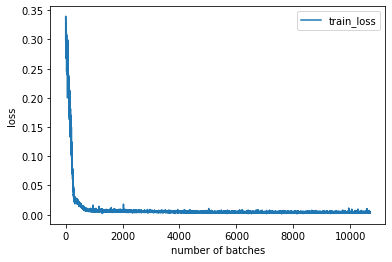

<Figure size 432x288 with 0 Axes>

In [31]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.4torchLSTMtrainloss.jpg')
#plt.clf()

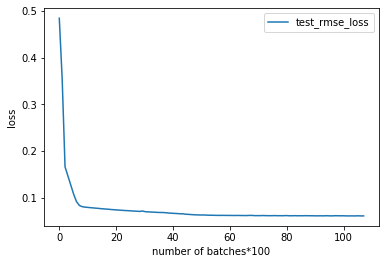

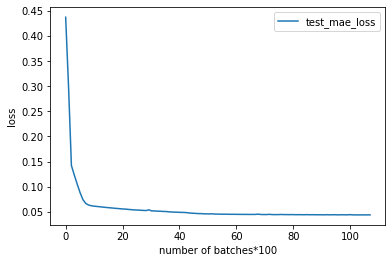

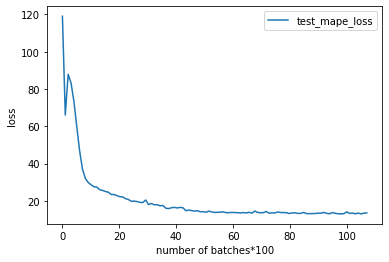

<Figure size 432x288 with 0 Axes>

In [32]:
#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.4torchLSTMtestrmseloss.jpg')
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.4torchLSTMtestrmaeloss.jpg')
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.4torchLSTMtestrmapeloss.jpg')
#plt.clf()